<a href="https://colab.research.google.com/github/forexms78/AI-05-/blob/main/%EB%AF%B8%EC%85%989_7%ED%8C%80_%EB%B0%95%EB%B3%91%ED%98%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모델을 활용하여 FashionMNIST 데이터셋을 조건부로 생성하는 작업을 수행
#cGAN (Conditional GAN) 모델

In [1]:
#@title 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
#@title Device 설정

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [22]:
# @title 드라이브 연결

from google.colab import drive
drive.mount('/content/drive')
g_path = '/content/drive/MyDrive/Colab Notebooks/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
#@title 일정한 결과값 확인을 위한 seed 설정

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)

In [43]:
#@title 하이퍼파라미터 및 환경 설정

image_size = 28
num_classes = 10
latent_dim = 100
batch_size = 64
num_epochs = 200
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
n_row_vis = 3
fixed_noise = torch.randn(num_classes * n_row_vis, latent_dim, device=device)

In [44]:
#@title Transform 설정

# 데이터 증강
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 평가용 정규화
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [45]:
#@title 데이터 셋, 데이터 로더

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transforms)
test_dataset  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [46]:
#@title 클래스 이름 설정

idx_to_class = {i: class_name for i, class_name in enumerate(train_dataset.classes)}
print("FashionMNIST classes:", idx_to_class)

FashionMNIST classes: {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


In [47]:
# @title CGAN 생성자

import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, latent_dim)

        self.init_size = image_size // 4

        self.l1 = nn.Sequential(
            nn.Linear(latent_dim * 2, 256 * self.init_size * self.init_size),
            nn.BatchNorm1d(256 * self.init_size * self.init_size, momentum=0.8),
            nn.ReLU(inplace=True)
        )

        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64, momentum=0.8),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), -1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), 256, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

기본적인 CGAN보다 좋은 결과를 내기위해서 DCGAN(Deep GAN) 사용했습니다
초기화, 순전파를 통해 조건과 이미지생성을 진행했고 업생플링까지 완성했습니다


In [48]:
# @title CGAN 판별자
class Discriminator(nn.Module):

    def __init__(self):

        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Conv2d(1 + num_classes, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128, momentum=0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(256 * (image_size // 4) * (image_size // 4), 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        batch_size = img.size(0)

        label = self.label_emb(labels)
        label = label.view(batch_size, num_classes, 1, 1)
        label = label.expand(batch_size, num_classes, image_size, image_size)

        d_in = torch.cat((img, label), 1)
        validity = self.model(d_in)
        return validity

판별기는 초기화 init부분에서 10차원 벡터로 변환하고
CNN구조로 이미지를 다,운 샘플링하고 특징을 추출했습니다
순전파에서도 마찬가지로 10차원 벡터로 변환한 후 이미지의 모든 픽셀 위치에 레이블의 정보를 주입하여
클래스에 해당하는지 판별하게 만들었습니다

In [49]:
#@title 모델 초기화 및 opt 설정

generator = Generator().to(device)
discriminator = Discriminator().to(device)
adversarial_loss = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

In [50]:
#@title 한 에폭 학습 함수

import torch
import matplotlib.pyplot as plt

def train_one_epoch(generator, discriminator,
                    optimizer_G, optimizer_D,
                    adversarial_loss,
                    train_loader,
                    device, latent_dim, num_classes):

    g_loss_sum = d_loss_sum = d_real_sum = d_fake_sum = 0.0
    num_batches = 0

    generator.train()
    discriminator.train()

    for imgs, labels in train_loader:
        batch_size = imgs.size(0)
        imgs, labels = imgs.to(device), labels.to(device)

        valid = torch.ones(batch_size, 1, device=device)
        fake  = torch.zeros(batch_size, 1, device=device)

        z = torch.randn(batch_size, latent_dim, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)
        gen_imgs = generator(z, gen_labels)

        optimizer_D.zero_grad()
        real_validity = discriminator(imgs, labels)
        d_real_loss = adversarial_loss(real_validity, valid)

        fake_validity = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(fake_validity, fake)

        d_loss = 0.5 * (d_real_loss + d_fake_loss)
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)
        g_loss.backward()
        optimizer_G.step()

        g_loss_sum   += g_loss.item()
        d_loss_sum   += d_loss.item()
        d_real_sum   += real_validity.mean().item()
        d_fake_sum   += fake_validity.mean().item()
        num_batches  += 1

    return {
        "g_loss":   g_loss_sum / num_batches,
        "d_loss":   d_loss_sum / num_batches,
        "d_real":   d_real_sum / num_batches,
        "d_fake":   d_fake_sum / num_batches,
    }

BCEL 의 타켓값을 판별자가 진짜는 1 가짜는 0 으로 예측하도록 손실함수를 작성했고
또 제너레잍너를 통해서 판별자를 속일 수 있는 생성자의 결과물도 준비했습니다

In [51]:
#@title 이미지 생성·시각화 함수

@torch.no_grad()
def visualize_generated_images(generator,
                               epoch,
                               latent_dim,
                               num_classes,
                               device,
                               idx_to_class,
                               n_row=3,
                               show_every=10):

    if epoch % show_every != 0:
        return

    generator.eval()

    n_col = num_classes
    labels = torch.arange(num_classes, device=device)\
                  .repeat(n_row, 1).view(-1)
    z = torch.randn(n_row * n_col, latent_dim, device=device)
    gen_imgs = generator(z, labels)
    gen_imgs = (gen_imgs + 1) / 2.0

    fig, axs = plt.subplots(n_row, n_col,
                            figsize=(n_col, n_row),
                            squeeze=False)

    for i in range(n_row):
        for j in range(n_col):
            idx = i * n_col + j
            axs[i, j].imshow(gen_imgs[idx, 0].cpu(), cmap="gray")
            axs[i, j].axis("off")
            if i == 0:
                axs[i, j].set_title(idx_to_class[j], fontsize=9)

    plt.tight_layout()
    plt.show()

학습에 대한 시각화를 위해 학습 그래프 코드를 추가하였습니다

In [54]:
# @title 전체 학습 루프 함수 (Loss 기록 및 시각화 추가)

import os
import torch
import matplotlib.pyplot as plt

def train_cgan(num_epochs,
               generator, discriminator,
               optimizer_G, optimizer_D,
               adversarial_loss,
               train_loader,
               device, latent_dim,
               num_classes, idx_to_class,
               g_path, fixed_noise):

    G_losses_history = []
    D_losses_history = []
    D_real_avg_history = []

    for epoch in range(1, num_epochs + 1):
        stats = train_one_epoch(generator, discriminator,
                                optimizer_G, optimizer_D,
                                adversarial_loss,
                                train_loader,
                                device, latent_dim, num_classes)

        G_losses_history.append(stats["g_loss"])
        D_losses_history.append(stats["d_loss"])
        D_real_avg_history.append(stats["d_real"])

        print(f"Epoch [{epoch}/{num_epochs}] "
              f"G_loss: {stats['g_loss']:.4f}  "
              f"D_loss: {stats['d_loss']:.4f}  "
              f"D(x): {stats['d_real']:.4f}  "
              f"D(G(x)): {stats['d_fake']:.4f}")

        torch.save(generator.state_dict(), os.path.join(g_path,f"generator_tr_epoch_{epoch}.pth"))
        torch.save(discriminator.state_dict(), os.path.join(g_path,f"discriminator_tr_epoch_{epoch}.pth"))

    print("CGAN 학습 완료")

    plot_cgan_losses(G_losses_history, D_losses_history)
    return G_losses_history, D_losses_history

def plot_cgan_losses(G_losses, D_losses):

    G_color = '#77DD77'
    D_color = '#A9A9A9'

    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss Over Epochs")

    plt.plot(G_losses, label="Generator Loss", color=G_color, linewidth=2)
    plt.plot(D_losses, label="Discriminator Loss", color=D_color, linewidth=2)

    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss Value", fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

에폭 관리 및 Loss 기록하여 모델 가중치를 저장합니다
plot_cgan_losses을 통해 그래프를 만듭니다

Epoch [1/200] G_loss: 0.7086  D_loss: 0.7023  D(x): 0.4989  D(G(x)): 0.5009
Epoch [2/200] G_loss: 0.7057  D_loss: 0.7000  D(x): 0.5012  D(G(x)): 0.5006
Epoch [3/200] G_loss: 0.7083  D_loss: 0.6995  D(x): 0.4982  D(G(x)): 0.4993
Epoch [4/200] G_loss: 0.7056  D_loss: 0.7000  D(x): 0.5000  D(G(x)): 0.5009
Epoch [5/200] G_loss: 0.7083  D_loss: 0.6985  D(x): 0.4995  D(G(x)): 0.4991
Epoch [6/200] G_loss: 0.7025  D_loss: 0.6979  D(x): 0.5009  D(G(x)): 0.5010
Epoch [7/200] G_loss: 0.7048  D_loss: 0.6979  D(x): 0.4995  D(G(x)): 0.5000
Epoch [8/200] G_loss: 0.7029  D_loss: 0.6970  D(x): 0.4995  D(G(x)): 0.4997
Epoch [9/200] G_loss: 0.7019  D_loss: 0.6969  D(x): 0.5004  D(G(x)): 0.5006
Epoch [10/200] G_loss: 0.6979  D_loss: 0.6964  D(x): 0.5007  D(G(x)): 0.5008
Epoch [11/200] G_loss: 0.7026  D_loss: 0.6969  D(x): 0.4986  D(G(x)): 0.4993
Epoch [12/200] G_loss: 0.6964  D_loss: 0.6961  D(x): 0.5001  D(G(x)): 0.5009
Epoch [13/200] G_loss: 0.6978  D_loss: 0.6954  D(x): 0.5001  D(G(x)): 0.5003
Epoch [1

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


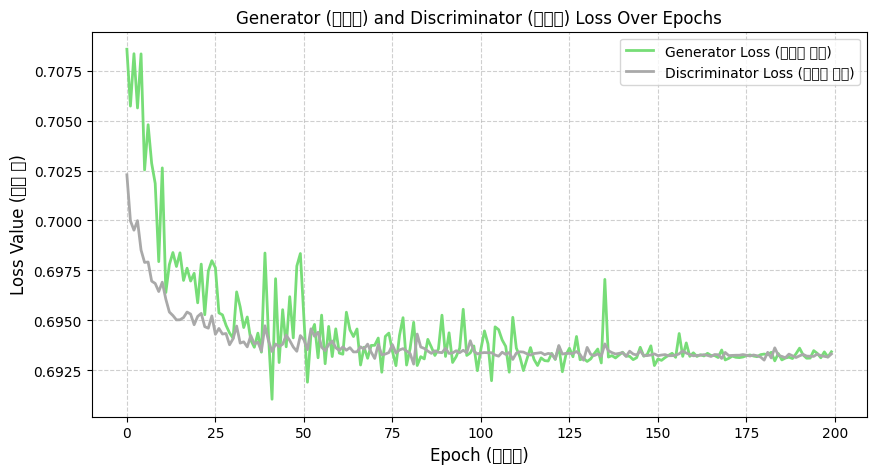

([0.7085669160778842,
  0.7057225364548311,
  0.7083426774946103,
  0.7056289142382933,
  0.7083339113543536,
  0.7025283643050488,
  0.7047912661454825,
  0.702859890994741,
  0.7018533109474793,
  0.6979424207449467,
  0.702631416986746,
  0.6963967948453005,
  0.6977961537426215,
  0.6983969885784426,
  0.6976992899039661,
  0.6983828543981255,
  0.6970017797657168,
  0.6976138252312186,
  0.6969695401979662,
  0.6973568611561871,
  0.6958819761840519,
  0.6978191555435977,
  0.6952859022851183,
  0.6974701005766895,
  0.6979901465271582,
  0.6976388041525762,
  0.6953772252429523,
  0.6952803534612473,
  0.6947614752661699,
  0.6943762547680056,
  0.6941106898316951,
  0.6964282942479099,
  0.6956781143191527,
  0.6946457466845319,
  0.6951728676682087,
  0.6940189368053794,
  0.6936568779858954,
  0.6943651987418437,
  0.6934136883028026,
  0.6983721085321675,
  0.6942389913078056,
  0.6910598092496014,
  0.6970891832733459,
  0.692895111625891,
  0.6955388512438548,
  0.693682223

In [53]:
#@title 학습 실행

train_cgan(
    num_epochs=num_epochs,
    generator=generator.to(device),
    discriminator=discriminator.to(device),
    optimizer_G=optimizer_G,
    optimizer_D=optimizer_D,
    adversarial_loss=torch.nn.BCELoss(),
    train_loader=train_loader,
    device=device,
    latent_dim=latent_dim,
    num_classes=num_classes,
    idx_to_class=idx_to_class,
    g_path=g_path,
    fixed_noise=fixed_noise
)

In [57]:
#@title 학습된 모델 로드

generator_loaded = Generator().to(device)
model_path = os.path.join(g_path, f"generator_tr_epoch_{num_epochs}.pth")
generator_loaded.load_state_dict(torch.load(model_path, map_location=device))
generator_loaded.eval()

print(f"Generator model loaded from {model_path}")

Generator model loaded from /content/drive/MyDrive/Colab Notebooks/data/generator_tr_epoch_200.pth


In [58]:
#@title Inception Model 준비

import torch.nn.functional as F
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
import numpy as np

inception_model_fid = inception_v3(weights="IMAGENET1K_V1", transform_input=False).to(device)
inception_model_fid.fc = torch.nn.Identity()
inception_model_fid.eval()

inception_model_is = inception_v3(weights="IMAGENET1K_V1", transform_input=False).to(device)
inception_model_is.eval()
print("Inception model loaded")

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 184MB/s] 


Inception model loaded


inception v3모델을 통해서 평가를 진행합니다

In [59]:
#@title Inception Feature 추출 함수 FID 계산 함수

def get_inception_features(images, model, batch_size=32, device=device):

    model.eval()
    n_images = images.shape[0]
    features = []
    norm_mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
    norm_std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)

    with torch.no_grad():
        for i in range(0, n_images, batch_size):
            batch = images[i:i+batch_size]
            if batch.shape[1] == 1:
                batch = batch.repeat(1,3,1,1)
            batch = F.interpolate(batch, size=(299,299), mode='bilinear', align_corners=False)
            batch = (batch - norm_mean) / norm_std
            pred = model(batch)
            features.append(pred.cpu().numpy())
    features = np.concatenate(features, axis=0)
    return features


def calculate_fid(real_images, generated_images, model, batch_size=32, device=device):

    feat_real = get_inception_features(real_images, model, batch_size, device)
    feat_gen  = get_inception_features(generated_images, model, batch_size, device)

    mu_real = np.mean(feat_real, axis=0)
    mu_gen  = np.mean(feat_gen, axis=0)
    sigma_real = np.cov(feat_real, rowvar=False)
    sigma_gen  = np.cov(feat_gen, rowvar=False)

    diff = mu_real - mu_gen
    covmean, _ = sqrtm(sigma_real.dot(sigma_gen), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid

In [60]:
#@title Inception Prediction 함수 IS 계산 함수

def get_inception_predictions(images, model, batch_size=32, device=device):

    model.eval()
    n_images = images.shape[0]
    preds = []
    norm_mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
    norm_std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)
    with torch.no_grad():
        for i in range(0, n_images, batch_size):
            batch = images[i:i+batch_size]
            if batch.shape[1] == 1:
                batch = batch.repeat(1,3,1,1)
            batch = F.interpolate(batch, size=(299,299), mode='bilinear', align_corners=False)
            batch = (batch - norm_mean) / norm_std

            logits = model(batch)
            p = F.softmax(logits, dim=1)
            preds.append(p.cpu().numpy())
    preds = np.concatenate(preds, axis=0)
    return preds

def calculate_inception_score(
        generated_images,
        model,
        batch_size: int = 32,
        splits: int = 10,
        device=device):

    preds = get_inception_predictions(
        generated_images, model,
        batch_size=batch_size, device=device)

    N = preds.shape[0]
    split_scores = []

    for i in range(splits):
        part = preds[i * (N // splits):(i + 1) * (N // splits), :]

        py = np.mean(part, axis=0)

        scores = []

        for j in range(part.shape[0]):
            pyx = part[j, :]
            kl = np.sum(pyx * (np.log(pyx + 1e-10) - np.log(py + 1e-10)))
            scores.append(kl)

        split_is = np.exp(np.mean(scores))
        split_scores.append(split_is)

    inception_score = np.mean(split_scores)
    inception_std   = np.std(split_scores)

    return inception_score, inception_std

FID 생성된 이미지 집단이 진짜 이미지 집단과 비슷한 크기와 모양으로 퍼져있는지를 평가하고
IS 확률과 집중이 좋은지 평균확률 분산이 좋은지 평가합니다

In [61]:
#@title 평가지표 확인

n_eval = 1000

z = torch.randn(n_eval, latent_dim, device=device)
eval_labels = torch.randint(0, num_classes, (n_eval,), device=device)
gen_imgs = generator(z, eval_labels)
gen_imgs = (gen_imgs + 1) / 2.0

real_imgs_list = []
for imgs, _ in test_loader:
    real_imgs_list.append(imgs)
    if len(real_imgs_list) * imgs.size(0) >= n_eval:
        break
real_imgs = torch.cat(real_imgs_list, 0)[:n_eval].to(device)
real_imgs = (real_imgs + 1) / 2.0

fid_score = calculate_fid(real_imgs, gen_imgs, inception_model_fid, batch_size=32, device=device)
inception_score, inception_std = calculate_inception_score(gen_imgs, inception_model_is, batch_size=32, splits=10, device=device)

print(f"FID score: {fid_score:.4f}")
print(f"Inception Score: Mean = {inception_score:.4f}, Std = {inception_std:.4f}")

/tmp/ipython-input-259829968.py:35: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = sqrtm(sigma_real.dot(sigma_gen), disp=False)
/tmp/ipython-input-259829968.py:35: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean, _ = sqrtm(sigma_real.dot(sigma_gen), disp=False)


FID score: 265.5664
Inception Score: Mean = 2.3473, Std = 0.0816


제가 학습한 Deep CGAN 은 성능이 매우 낮다 학습이 성공적이 못했다고 평가할 수 있습니다
이유는 FID 스코어가 265.57로  FID는 낮을 수록 좋은데 이 점수로보아 현실성이 떨어지고 다양성도 부족하고 볼 수 있습니다

반대로 IS 점수는 높을수록 좋습니다 보통은 3.5점 이상을 볼 수 있는데 2.35점이라는 점수로 선명도와 클래스의 다양성이 떨어진다고 볼 수 있습니다

그리고 Matrix is singular 로 보아서 수학적 계산이 불완정하여 Mode Collapse의 징후가 나타나고있습니다